# Please use py37tf_gpu env(kernel) to use GPU to accelerate the CNN training

In [1]:
#the following code will check if you have utilize GPU or CPU or Both (here I have both gpu and cpu available for calculation--see below)
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 2674792723143852840
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 2204421324
locality {
  bus_id: 1
  links {
  }
}
incarnation: 7995771713006532706
physical_device_desc: "device: 0, name: GeForce GTX 1060 3GB, pci bus id: 0000:01:00.0, compute capability: 6.1"
]


In [2]:
import itertools

import numpy as np
np.random.seed(1)

import matplotlib.pyplot as plt
from matplotlib.colors import colorConverter, ListedColormap

from sklearn.datasets import make_circles
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

from scipy import signal

import cv2

%matplotlib inline

from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers.convolutional import Conv2D, MaxPooling2D
from keras.optimizers import SGD
from keras.utils import np_utils
from keras.datasets import mnist
import keras.backend as K

import tensorflow as tf
from keras.backend.tensorflow_backend import set_session
from tensorflow.python.keras import backend as K
config = tf.compat.v1.ConfigProto()
config.gpu_options.allow_growth=True
K.set_session(tf.compat.v1.Session(config=config))

Using TensorFlow backend.


note: by default, Keras uses Tensorflow as Backend

In [3]:
import keras
keras.__version__

'2.3.1'

# 1. 卷积神经网络

## 1.1 加载MNIST数据

In [4]:
(X_train, y_train), (X_test, y_test) = mnist.load_data()

In [5]:
X_train.shape

(60000, 28, 28)

In [6]:
def plot_figure(im, interp = False):
    f = plt.figure(figsize = (3, 6))
    plt.gray()
    plt.imshow(im, interpolation = None if interp else 'none')

## 1.2 卷积

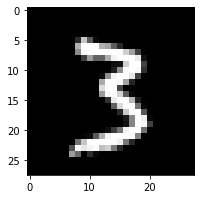

In [7]:
plot_figure(X_train[130])

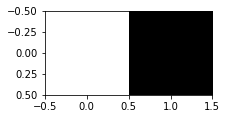

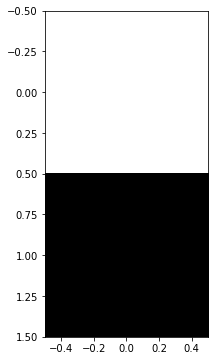

In [8]:
#Self define two filters, one is horizontal, one is vertical.
vertical = [[1, -1]]

plot_figure(vertical)

horizontal = [[1], [-1]]

plot_figure(horizontal)

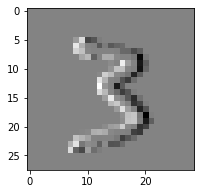

In [9]:
#When apply vertical filter to image, it should show the vertical features (e.g. vertical black line, vertical white line)
plot_figure(signal.convolve(X_train[130], vertical)) #note: from scipy import signal

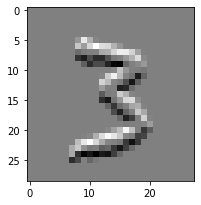

In [10]:
#When apply horizontal filter to image, it should show the horizontal features (e.g. horizontal black line, horizontal white line)
plot_figure(signal.convolve(X_train[130], horizontal))

Another demo on horizontal and vertical filter

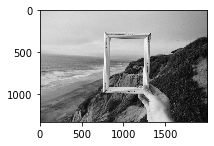

In [11]:
# Load an color image in grayscale
demo_image = cv2.imread('./pic/demo.jpg',0)
plot_figure(demo_image[:, ::-1])

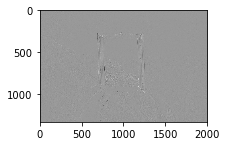

In [12]:
plot_figure(signal.convolve(demo_image, vertical))

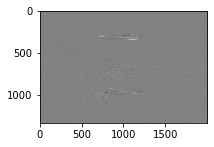

In [13]:
plot_figure(signal.convolve(demo_image, horizontal))

## 1.3 Simple Deep Neural Network with MNIST DATA, with one hidden layer (not CNN)

- MNIST data is handwritten numeric numbers from 0~9
- So output y is from 0~9 (10 categories)
- This is a image categorization problem

<img src='./pic/image_classification_NN.jpg'>

### Step 1. Flatten

For Traditional NN network, we need to reshape input to "xxx by 1" matrix (this process is called "flatten"), here for each image, 28x28 matrix -> 784x1 matrix 

In [14]:
X_train.shape

(60000, 28, 28)

In [15]:
# Flatten 28*28 images to a 784 vector for each image
num_pixels = X_train.shape[1] * X_train.shape[2]
X_train = X_train.reshape(X_train.shape[0], num_pixels).astype('float32')
X_test = X_test.reshape(X_test.shape[0], num_pixels).astype('float32')

In [16]:
num_pixels

784

In [17]:
X_train.shape

(60000, 784)

In [18]:
X_test.shape

(10000, 784)

In [19]:
# normalize inputs from 0-255 to 0-1 (grey scale, each pixel is from 0-255)
X_train = X_train / 255.0
X_test = X_test / 255.0

In [20]:
y_train[:10]

array([5, 0, 4, 1, 9, 2, 1, 3, 1, 4], dtype=uint8)

### Step 1.5. One Hot Encoding output Y

- transfer output y to one hot encoding (matrix of 1 or 0), so that output y is 10x1 Matrix for each output (e.g. [1,0,0,...,0])

In [21]:
num_classes = len(set(y_train))
y_train = np_utils.to_categorical(y_train)
y_test = np_utils.to_categorical(y_test)

In [22]:
y_train

array([[0., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 1., 0.]], dtype=float32)

### Step 2. Create NN Model (Dense Network) (Fully-Connected)

In [23]:
model = Sequential()
model.add(Dense(num_pixels, input_dim = num_pixels, activation = 'relu')) #add one hidden layer (filter), which is the same size as input dimension
model.add(Dense(num_classes, activation = 'softmax')) #output y size = num_classes = 10 (0~9, 10 categories)
                                                #please note: input_dim is actually optional, because Dense() can auto-detect input dim
model.compile(loss = 'categorical_crossentropy', optimizer = 'adam', metrics = ['accuracy'])

In [24]:
# Fit the model
model.fit(X_train, y_train, validation_data = (X_test, y_test), epochs = 10, batch_size = 200)
# Final evaluation of the model
scores = model.evaluate(X_test, y_test, verbose = 0) #verbose=0-> 0 means do not print anything when running the model, default is 1, which is print while running the model.
print("Baseline Error: %.2f%%" % (100 - scores[1] * 100))

Train on 60000 samples, validate on 10000 samples
Epoch 1/10
60000/60000 [==============================] - 1s 21us/step - loss: 0.2824 - accuracy: 0.9202 - val_loss: 0.1336 - val_accuracy: 0.9622
Epoch 2/10
60000/60000 [==============================] - 1s 14us/step - loss: 0.1134 - accuracy: 0.9678 - val_loss: 0.0962 - val_accuracy: 0.9710
Epoch 3/10
60000/60000 [==============================] - 1s 14us/step - loss: 0.0722 - accuracy: 0.9794 - val_loss: 0.0782 - val_accuracy: 0.9757
Epoch 4/10
60000/60000 [==============================] - 1s 15us/step - loss: 0.0516 - accuracy: 0.9850 - val_loss: 0.0658 - val_accuracy: 0.9794
Epoch 5/10
60000/60000 [==============================] - 1s 15us/step - loss: 0.0378 - accuracy: 0.9894 - val_loss: 0.0681 - val_accuracy: 0.9795
Epoch 6/10
60000/60000 [==============================] - 1s 15us/step - loss: 0.0286 - accuracy: 0.9924 - val_loss: 0.0687 - val_accuracy: 0.9789
Epoch 7/10
60000/60000 [==============================] - 1s 15us/st

In [25]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 784)               615440    
_________________________________________________________________
dense_2 (Dense)              (None, 10)                7850      
Total params: 623,290
Trainable params: 623,290
Non-trainable params: 0
_________________________________________________________________


> Note: from hidden layer to final output (dense_2 layer) has 7850 parameters, why it is not 7840 (i.e. 784 hidden layer size * 10 output size)?
- Reason: based on y=wx+b model, w is 10x784 matrix, and b(bias) is 10x1 matrix, so there are in total 784x10+10x1=7850 parameters.
- note: x here is hidden layer, size = 784x1 matrix, y here is final output, size = 10x1 matrix

## 1.4 Convolution Neural Network with MNIST DATA

For CNN network, we need to reshape the input to 3-Dim matrix, where the third channel is the color channel

- here for each image, 28x28 matrix -> 28x28x1 matrix
- Because our image is greyscale, so the third dim (color channel) only has size=1 (i.e. 0~255)
- If image is color scale, the third dim (color channel) will has size =3 (e.g. (R,G,B)), i.e. 28x28x3 matrix

### Step 1. Reshape to 3-Dim matrix for each image input Matrix

In [26]:
# original X_train shape is = (60000, 28, 28)

In [27]:
X_train = X_train.reshape(X_train.shape[0], 28, 28, 1).astype('float32')
X_test = X_test.reshape(X_test.shape[0], 28, 28, 1).astype('float32')

In [28]:
X_train.shape

(60000, 28, 28, 1)

### Step 1.5. One Hot Encoding output Y

- it is already finished under section 1.3, see "y_train = np_utils.to_categorical(y_train)" code above

### Step 2. Create CNN Model

In [29]:
model = Sequential()

model.add(Conv2D(32, 3, activation = 'relu'))
#Conv2D(32, 3): Added hidden layer contains 32 CNN filters, each is 3x3 matrix -> 32x3x3 matrix
#note: Conv2D (CNN) network can auto detect the input shape, so no need to tell input_dim
model.add(Conv2D(32, 3, activation = 'relu'))
#do same convolution again

#add maxpooling after each convolution layer (refer to lecture notes, we can do maxpooling, minpooling, average pooling ...)
model.add(MaxPooling2D(pool_size = 2))
#pool_size = 2: here we use 2x2 pooling



#same thing, do convo2D twice, then do another max_pooling; this time we increase the # of filters from 32 to 64
model.add(Conv2D(64, 3, activation = 'relu'))
model.add(Conv2D(64, 3, activation = 'relu'))
model.add(MaxPooling2D(pool_size = 2))

### Step 3. Flatten to use Dense NN Network (Fully-connected)

In [30]:
model.add(Flatten()) #flatten output from above to 1-D matrix:"xxx by 1" matrix, where xxx is auto-calculated by Flatten() func
model.add(Dense(128, activation = 'relu')) #add another dense layer, with 128 filters. (128x1 matrix). Actually, we don't need to specify input_dim, Dense() func can auto-detect
model.add(Dense(num_classes, activation = 'softmax')) #output layer, with size of 10 (=num_classes), 10x1 matrix

#compile
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [31]:
# Fit the model
model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs = 10, batch_size = 200)
# Final evaluation of the model
scores = model.evaluate(X_test, y_test, verbose=0)
print("Large CNN Error: %.2f%%" % (100 - scores[1] * 100))

Train on 60000 samples, validate on 10000 samples
Epoch 1/10
60000/60000 [==============================] - 8s 128us/step - loss: 0.2275 - accuracy: 0.9314 - val_loss: 0.0545 - val_accuracy: 0.9828
Epoch 2/10
60000/60000 [==============================] - 4s 72us/step - loss: 0.0543 - accuracy: 0.9828 - val_loss: 0.0349 - val_accuracy: 0.9886
Epoch 3/10
60000/60000 [==============================] - 4s 71us/step - loss: 0.0389 - accuracy: 0.9879 - val_loss: 0.0337 - val_accuracy: 0.9898
Epoch 4/10
60000/60000 [==============================] - 4s 71us/step - loss: 0.0285 - accuracy: 0.9911 - val_loss: 0.0302 - val_accuracy: 0.9907
Epoch 5/10
60000/60000 [==============================] - 4s 71us/step - loss: 0.0221 - accuracy: 0.9932 - val_loss: 0.0320 - val_accuracy: 0.9904
Epoch 6/10
60000/60000 [==============================] - 4s 69us/step - loss: 0.0172 - accuracy: 0.9943 - val_loss: 0.0244 - val_accuracy: 0.9929
Epoch 7/10
60000/60000 [==============================] - 4s 69us/s

In [32]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 26, 26, 32)        320       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 24, 24, 32)        9248      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 12, 12, 32)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 10, 10, 64)        18496     
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 8, 8, 64)          36928     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 4, 4, 64)          0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 1024)             

## Summary

- Comparing Traditional NN vs. CNN model, we can see:
- 1. Total # parameters of CNN is 197K, while total # parameters of NN is 623K, therefore, CNN has less parameters than NN
- 2. But accuracy of CNN is actually higher than traditional NN, i.e. error rate 0.63% vs 1.84%